In [1]:
!git clone https://github.com/swrao5/rossman_sales_project.git

Cloning into 'rossman_sales_project'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 49 (delta 7), reused 37 (delta 5), pack-reused 0
Receiving objects: 100% (49/49), 20.22 MiB | 11.97 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [7]:
import os
from pathlib import Path
base_directory = Path('/content/rossman_sales_project')
os.chdir(base_directory)

In [8]:
from src.data_preprocesing import load_data, preprocess_data
from src.feature_engineering import build_features
from src.model_training import train_random_forest, train_xgboost, train_lightgbm, evaluate_model
from src.hyperparameter_optimization import optimize
from hyperopt import hp, tpe, fmin
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import json

In [15]:
# Example: Creating a full path using the base directory
data_directory = base_directory / 'data'
raw_path = data_directory / 'raw'
preprocessed_path = data_directory / 'processed'
# Specify the path for the new directory
results_path = base_directory / 'results'
# Create the new directory
results_path.mkdir(parents=True, exist_ok=True)

In [10]:
# Load data
df_train, df_test, df_store = load_data(raw_path)

# Preprocess data
df_train_preprocessed, df_test_preprocessed, features_train, features_test = preprocess_data(df_train, df_test, df_store, preprocessed_path)

#splitting the data into trainig and validation
train_features, valid_features , train_target, valid_target = train_test_split(df_train_preprocessed[features_train], df_train_preprocessed['Sales'], test_size=0.2, random_state=42)


In [11]:
# Hyperparameter search space for XGBoost with GPU acceleration
xgb_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 50)),
    'tree_method': 'hist',  # Enable GPU acceleration
    'device' : 'cuda'
    # Add more hyperparameters as needed
}

In [12]:
# Hyperparameter optimization for XGBoost
best_params_xgb = optimize(xgb_space, XGBRegressor(), train_features, train_target)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:40:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



100%|██████████| 50/50 [32:50<00:00, 39.41s/trial, best loss: 488641.13840388897]


In [13]:
best_params_xgb

{'learning_rate': 0.22335161956757119, 'max_depth': 6, 'n_estimators': 16}

In [21]:
best_params_xgb_converted = {i: float(v) for i, v in best_params_xgb.items()}

with open(results_path/'best_params_xgb.json', 'w') as json_file:
    json.dump(best_params_xgb_converted, json_file)

In [22]:
# Train the models with the best hyperparameters
xgb_model = XGBRegressor(**best_params_xgb).fit(train_features, train_target)

In [28]:
import pickle
with open(results_path/'best_params_xgb.pkl', 'wb') as model:
    pickle.dump(xgb_model, model)

In [23]:
# Evaluate the models on the test set
xgb_score = evaluate_model(xgb_model, valid_features, valid_target)
print(f'XGBoost Test RMSE: {xgb_score}')

XGBoost Test RMSE: 2304.669308395054


In [24]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 4.0 MB/s eta 0:00:00


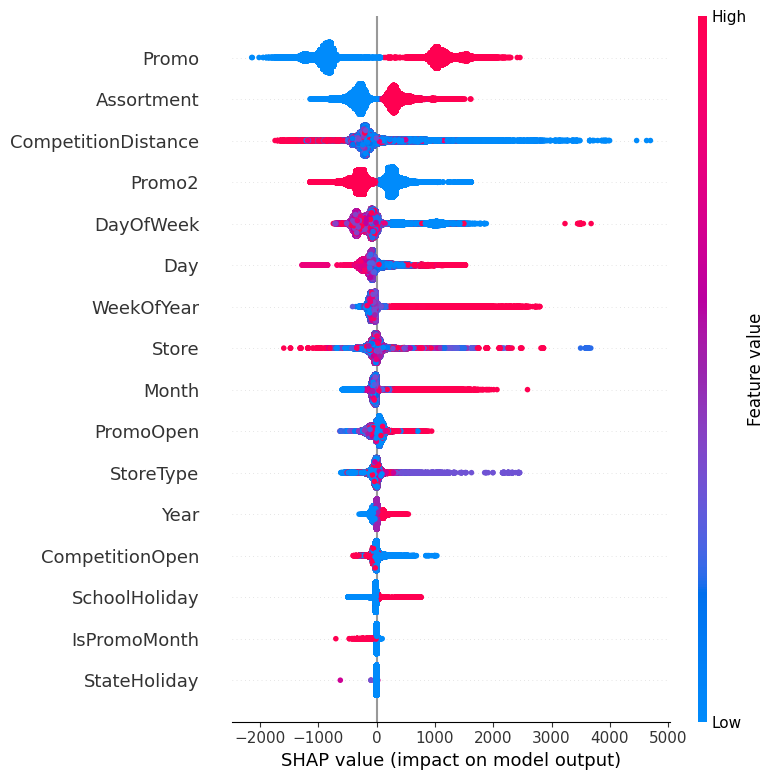

In [30]:
import shap
# Create a SHAP explainer
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(valid_features)

# Summary plot of feature importance
shap.summary_plot(shap_values, valid_features, show=False)